# Transfer Entropy Analysis

This jupyter notebook analyze the Transfer Entropy (TE) evolution between Tweets and BTC returns. This analysis aim to determine if an information transfer can occur from twitter sentiment to BTC price evolution, or vice versa.

## Import

In [1]:
import numpy as np
from tqdm import tqdm
from helpers.time_series_labelization import TweetsLabelization, BtcLabelization
from helpers.transfer_entropy import TweetsToBtcTransferEntropy

#auto reload
%load_ext autoreload
%autoreload 2

## Thresholds Selection

Before conducting the final analysis, we must select the thresholds for BTC and Twitter.

### BTC Threshold
The threshold in the BTC use case determines whether BTC's behavior is classified as bullish, bearish, or neutral based on its returns evolution. For example, if the threshold is set at 0.1 (10%), the following classifications apply:
- **Neutral**: Returns between -10% and 10%.
- **Bullish**: Returns greater than 10%.
- **Bearish**: Returns less than -10%.

### Twitter Threshold
The Twitter threshold is used to classify aggregated sentiment scores within a specific time granularity (e.g., hourly or daily). If the weighted average sentiment score (calculated using sentiment scores from language model) falls below, within, or above the range \([-threshold, + threshold]\), it will be classified as:
- **Down**: Sentiment below the lower threshold.
- **Neutral**: Sentiment within the threshold range.
- **Up**: Sentiment above the upper threshold.

Refer to the paper for further explanation.

To find the optimal threshold to use we conduct a grid search. This step give us also insight on the optimal information transfer of Twitter to BTC, i.e. Twitter has a greater transfer information for high or low BTC movement?


In [9]:
# Define the range of thresholds to search
tweet_thresholds = np.arange(0.1, 0.5, 0.1)
btc_thresholds = np.arange(0.001, 0.01, 0.001)

# Initialize variables to store the best parameters and the highest mean transfer entropy
best_tweet_threshold = None
best_btc_threshold = None
highest_mean_te = -np.inf

# Calculate the total number of iterations
total_iterations = len(tweet_thresholds) * len(btc_thresholds)

# Initialize the progress bar
with tqdm(total=total_iterations, desc="Grid Search Progress") as pbar:
    # Perform grid search
    for tweet_threshold in tweet_thresholds:
        for btc_threshold in btc_thresholds:
            # Labelize the time series data
            tweet_labelizer = TweetsLabelization('clean_data/twitter.parquet')
            btc_labelizer = BtcLabelization('clean_data/btc.parquet')
            tweets_labels = tweet_labelizer.labelize(threshold=tweet_threshold, granularity='h')
            btc_labels = btc_labelizer.labelize(threshold=btc_threshold, granularity='h')

            # Compute the mean transfer entropy
            TE_computer = TweetsToBtcTransferEntropy(tweets_labels, btc_labels)
            mean_te = TE_computer.compute_mean_transfer_entropy(delays=range(0, 10000), k=1)

            # Update the best parameters if the current mean transfer entropy is higher
            if mean_te > highest_mean_te:
                highest_mean_te = mean_te
                best_tweet_threshold = tweet_threshold
                best_btc_threshold = btc_threshold
            
            # Update the progress bar
            pbar.update(1)

# Print the best parameters and the highest mean transfer entropy
print(f"Optimal pair threshold:\n"
      f"\tTwitter: {best_tweet_threshold}\t|\tBTC: {best_btc_threshold}\n"
      f"\tProduce mean transfer entropy of {highest_mean_te:.6f}")

Grid Search Progress: 100%|██████████| 36/36 [00:07<00:00,  5.06it/s]

Optimal pair threshold:
	Twitter: 0.4	|	BTC: 0.008
	Produce mean transfer entropy of 0.014363


## Transfer Entropy (hourly)

This section conducts our Transfer Entropy analysis on a hourly granularity.

### Labelization

In [3]:
# Initiate labelization classes for both dataset
tweet_labelizer = TweetsLabelization('clean_data/twitter.parquet')
btc_labelizer = BtcLabelization('clean_data/btc.parquet')

# Run the labelization using threshold found above
tweets_labels = tweet_labelizer.labelize(threshold=0.1, granularity='h', verbose=True)
btc_labels = btc_labelizer.labelize(threshold=0.004, granularity='h', verbose=True)

########## Tweets Labelization ##########
First timestamp: 2017-08-17 05:00:00+00:00
Last timestamp: 2019-11-23 14:00:00+00:00
Number of elements: 19882
Number of NaN: 0
Label distribution: 
	1: 12188 (61.30%)
	2: 5496 (27.64%)
	0: 2198 (11.06%)
########## BTC Labelization ##########
First timestamp: 2017-08-17 05:00:00+00:00
Last timestamp: 2019-11-23 14:00:00+00:00
Number of elements: 19882
Number of NaN: 0
Label distribution: 
	1: 11671 (58.70%)
	2: 4228 (21.27%)
	0: 3983 (20.03%)


### Tweets to BTC ($TE^{T \rightarrow B}$)

We perform first the information transfer between Bitcoin related tweets and Bitcoin return evolution, referred as $T^{T \rightarrow B}$.

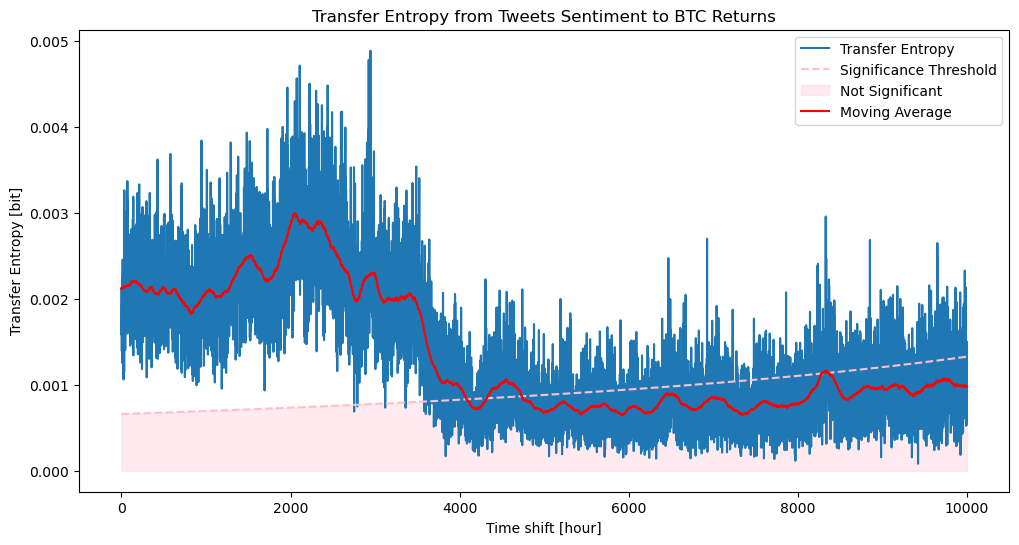

In [4]:
TE_computer = TweetsToBtcTransferEntropy(tweets_labels, btc_labels)
TE_computer.plot_transfer_entropy_on_lags(delays=range(0, 10000), k=1, moving_average_window=200,
                                          case="tweet_to_btc_hours")

### BTC to Tweets ($TE^{B \rightarrow T}$)

Additionnaly, we perform the information transfer between Bitcoin return evolution and Bitcoin related tweets, referred as $TE^{B \rightarrow T}$.

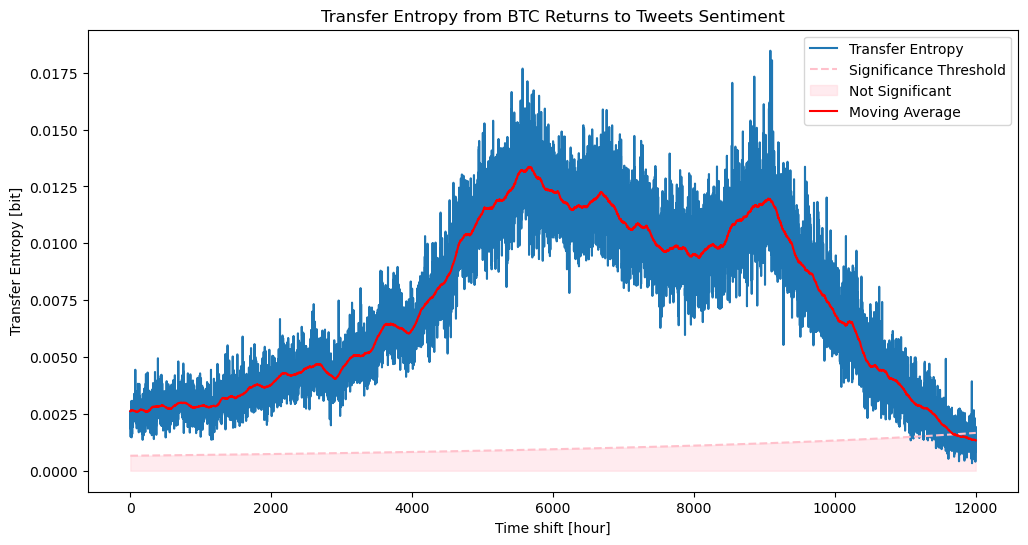

In [5]:
TE_computer = TweetsToBtcTransferEntropy(btc_labels, tweets_labels)
TE_computer.plot_transfer_entropy_on_lags(delays=range(0, 12000), k=1, moving_average_window=200,
                                          case="btc_to_tweet_hours")

## Transfer Entropy (daily)

### Labelization

In [16]:
tweet_labelizer = TweetsLabelization('clean_data/twitter.parquet')
btc_labelizer = BtcLabelization('clean_data/btc.parquet')
tweets_labels = tweet_labelizer.labelize(threshold=0.4, granularity='d')
btc_labels = btc_labelizer.labelize(threshold=0.08, granularity='d')

### Tweets to BTC ($TE^{T \rightarrow B}$)

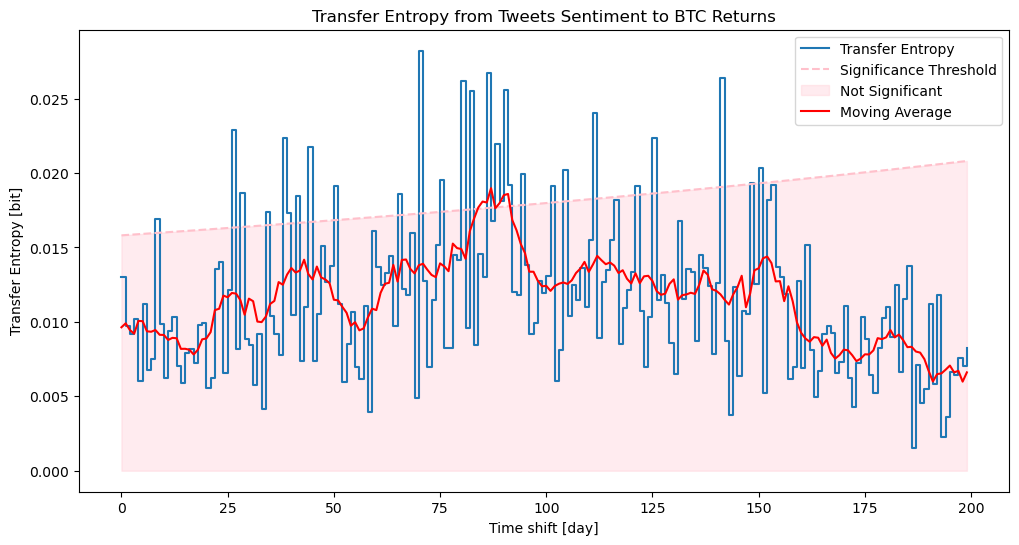

In [17]:
TE_computer = TweetsToBtcTransferEntropy(tweets_labels, btc_labels)
TE_computer.plot_transfer_entropy_on_lags(delays=range(0, 200), k=1, moving_average_window=10, case="tweet_to_btc_days")

### BTC to Tweets ($TE^{B \rightarrow T}$)

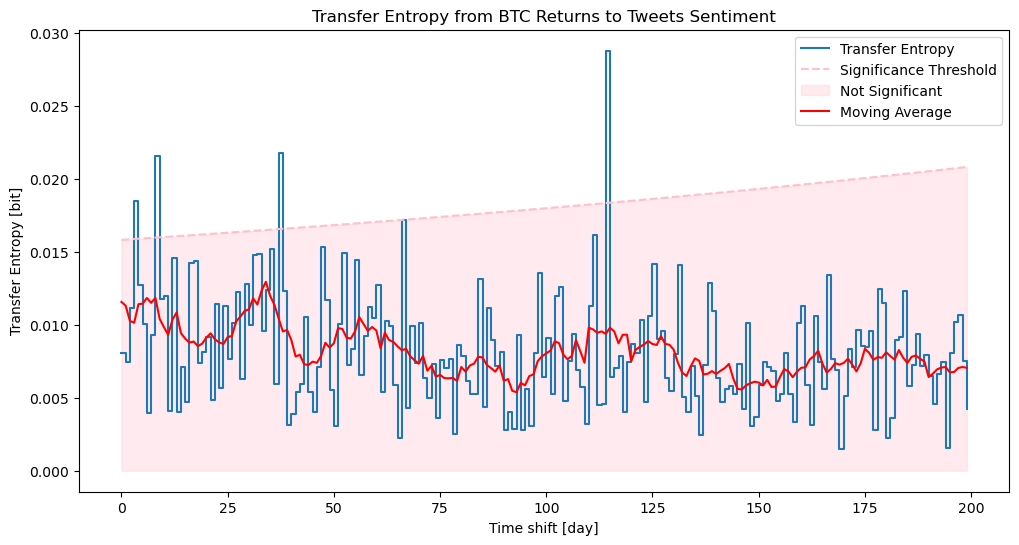

In [20]:
TE_computer = TweetsToBtcTransferEntropy(btc_labels, tweets_labels)
TE_computer.plot_transfer_entropy_on_lags(delays=range(0, 200), k=1, moving_average_window=10, 
                                          case="btc_to_tweet_days")